In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pdb

Automatic pdb calling has been turned ON


In [2]:
import pdb
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data_old', 'df_raw_data', 'df_deaths_recoveries', 'df_districts', 'df_travel_history', 'df_resources'])

In [5]:
regions = [('Delhi', ''), ('Karnataka', 'Bengaluru Urban'), ('Maharashtra', 'Mumbai'), ('Maharashtra', 'Pune'), ('Gujarat', 'Ahmedabad'), ('Rajasthan', 'Jaipur')]
state, district = regions[2]
df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe = 'districts_daily')

/home/users/namrata/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Create train-val splits

In [79]:
df_train = df_district
# df_train = df_district.iloc[:-5, :]
# df_val = df_district.iloc[-5:, :]

In [7]:
df_val

,state,district,date,hospitalised,total_infected,deceased,recovered
24,Maharashtra,Mumbai,2020-05-18,16848,21335,757,3730
25,Maharashtra,Mumbai,2020-05-19,16848,21335,757,3730
26,Maharashtra,Mumbai,2020-05-20,18925,24118,841,4352
27,Maharashtra,Mumbai,2020-05-21,19916,25500,882,4702
28,Maharashtra,Mumbai,2020-05-22,20573,27251,909,5769


## Set priors for parameters of interest

In [8]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1.6, 3)
prior_ranges['T_inc'] = (4, 5)
prior_ranges['T_inf'] = (3, 4)
prior_ranges['T_recov_severe'] = (5, 60)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)
prior_ranges['sigma'] = (0, 1)

def param_init(prior_ranges):
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [55]:
proposal_sigmas = OrderedDict()
proposal_sigmas['R0'] = 20
proposal_sigmas['T_inc'] = 100
proposal_sigmas['T_inf'] = 10
proposal_sigmas['T_recov_severe'] = np.exp(100)
proposal_sigmas['P_severe'] = 10
proposal_sigmas['intervention_amount'] = 10
proposal_sigmas['sigma'] = 10

def proposal(theta_old, proposal_sigmas):
    theta_new = [np.nan]
    
    while np.isnan(theta_new).any():
        theta_new = np.random.normal(loc=np.exp([*theta_old.values()]), scale=[*proposal_sigmas.values()])
        theta_new = np.log(theta_new)
    
    return dict(zip(theta_old.keys(), theta_new))


In [56]:
theta = param_init(prior_ranges)
new_theta = proposal(theta, proposal_sigmas)
for key in theta:
    print(key, theta[key], new_theta[key])

R0 1.9277615476469312 3.531250535828897
T_inc 4.430904514834004 3.134727151184366
T_inf 3.4518924810777403 3.999698390470837
T_recov_severe 7.587467701637214 100.45097953749615
P_severe 0.485605436259683 2.0633092121962404
intervention_amount 0.9283383372642027 -0.5640008108133931
sigma 0.4488717608516448 2.279485745908467


<ipython-input-55-11c7de85d247>:15: RuntimeWarning: invalid value encountered in log
  theta_new = np.log(theta_new)


## Log Likelihood and Prior

In [11]:
def log_likelihood(theta, df_train, fit_days=10):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])[-fit_days:]
    true = np.array(df_train['total_infected'])[-fit_days:]
    sigma = theta['sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [12]:
def accept(theta_old, theta_new, df_train):    
    x_new = log_likelihood(theta_new, df_train) + log_prior(theta_new)
    x_old = log_likelihood(theta_old, df_train) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

## Metropolis loop

In [13]:
def metropolis(prior_ranges, proposal_sigmas, df_train, iter=1000):
    theta = param_init(prior_ranges)
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta, proposal_sigmas)
        if accept(theta, theta_new, df_train):
            theta = theta_new
        else:
            rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

## Prediction Interval calculator

In [14]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Run multiple chains in parallel

In [69]:
n_chains = 5
mcmc = Parallel(n_jobs=n_chains)(delayed(metropolis)(prior_ranges, proposal_sigmas, df_train, iter=20000) for run in range(n_chains))

## Visualize the samples and intervals

In [139]:
def visualize(compartments: list, end_date: str = None): 
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    combined_acc = list()
    for k, run in enumerate(mcmc):
        burn_in = int(len(run) / 2)
        combined_acc += run[0][burn_in:]

    n_samples = 1000
    sample_indices = np.random.uniform(0, len(combined_acc), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(combined_acc[int(i)], default_params, data_split, end_date=end_date))

    for df in pred_dfs:
        df.set_index('date', inplace=True)

    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''

    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

    data_split.set_index("date", inplace=True)

    plt.figure(figsize=(15, 10))
    
    color = plt.cm.rainbow(np.linspace(0,1,len(compartments)))
    for i, bucket in enumerate(compartments):
        plt.plot(data_split.index.array, data_split[bucket].tolist(), c=color[i], marker='o', label='Actual {}'.format(bucket))
        plt.plot(result.index.array, result[bucket].tolist(), c=color[i], label='Estimated {}'.format(bucket))
        plt.plot(result.index.array, result['{}_low'.format(bucket)].tolist(), c=color[i], linestyle='dashdot')
        plt.plot(result.index.array, result['{}_high'.format(bucket)].tolist(), c=color[i], linestyle='dashdot')
    plt.axvline(x=df_train['date'][len(df_train)-1], c='b', linestyle='dashed', label='train-test boundary')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title("95% confidence intervals for {}, {}".format(district, state))
    plt.tight_layout()
    
    plt.savefig('./mcmc_confidence_intervals_{}_{}.png'.format(district, state))
    plt.show()

100%|██████████| 59/59 [00:08<00:00,  6.99it/s]


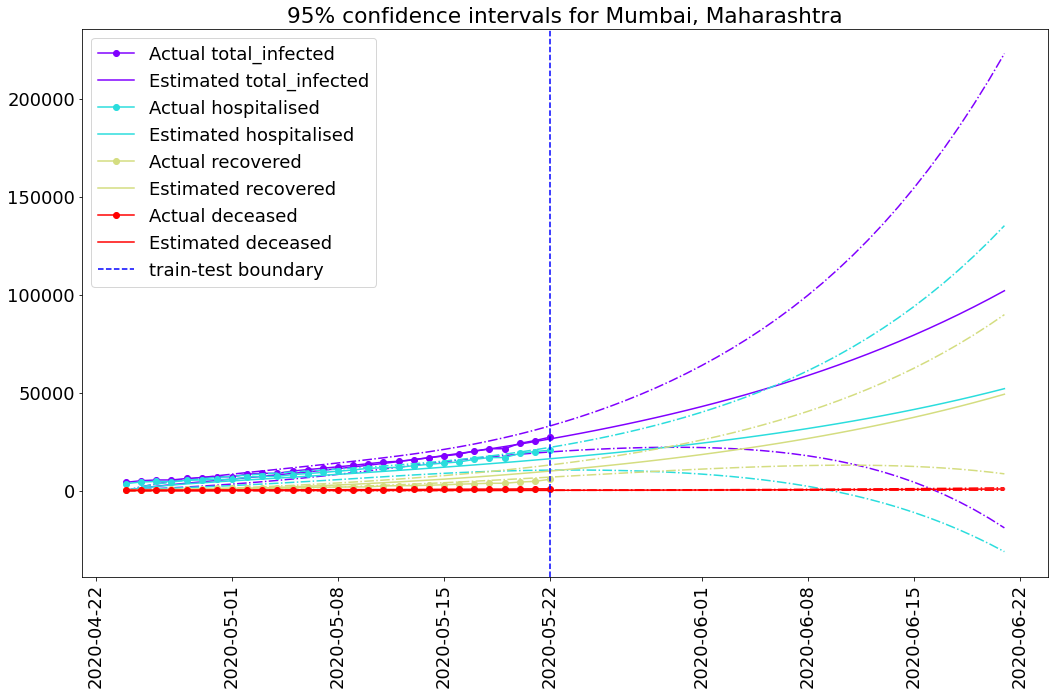

In [140]:
visualize(["total_infected", "hospitalised", "recovered", "deceased"], end_date="2020-06-21")

## Visualize all runs separately

100%|██████████| 29/29 [00:04<00:00,  6.59it/s]


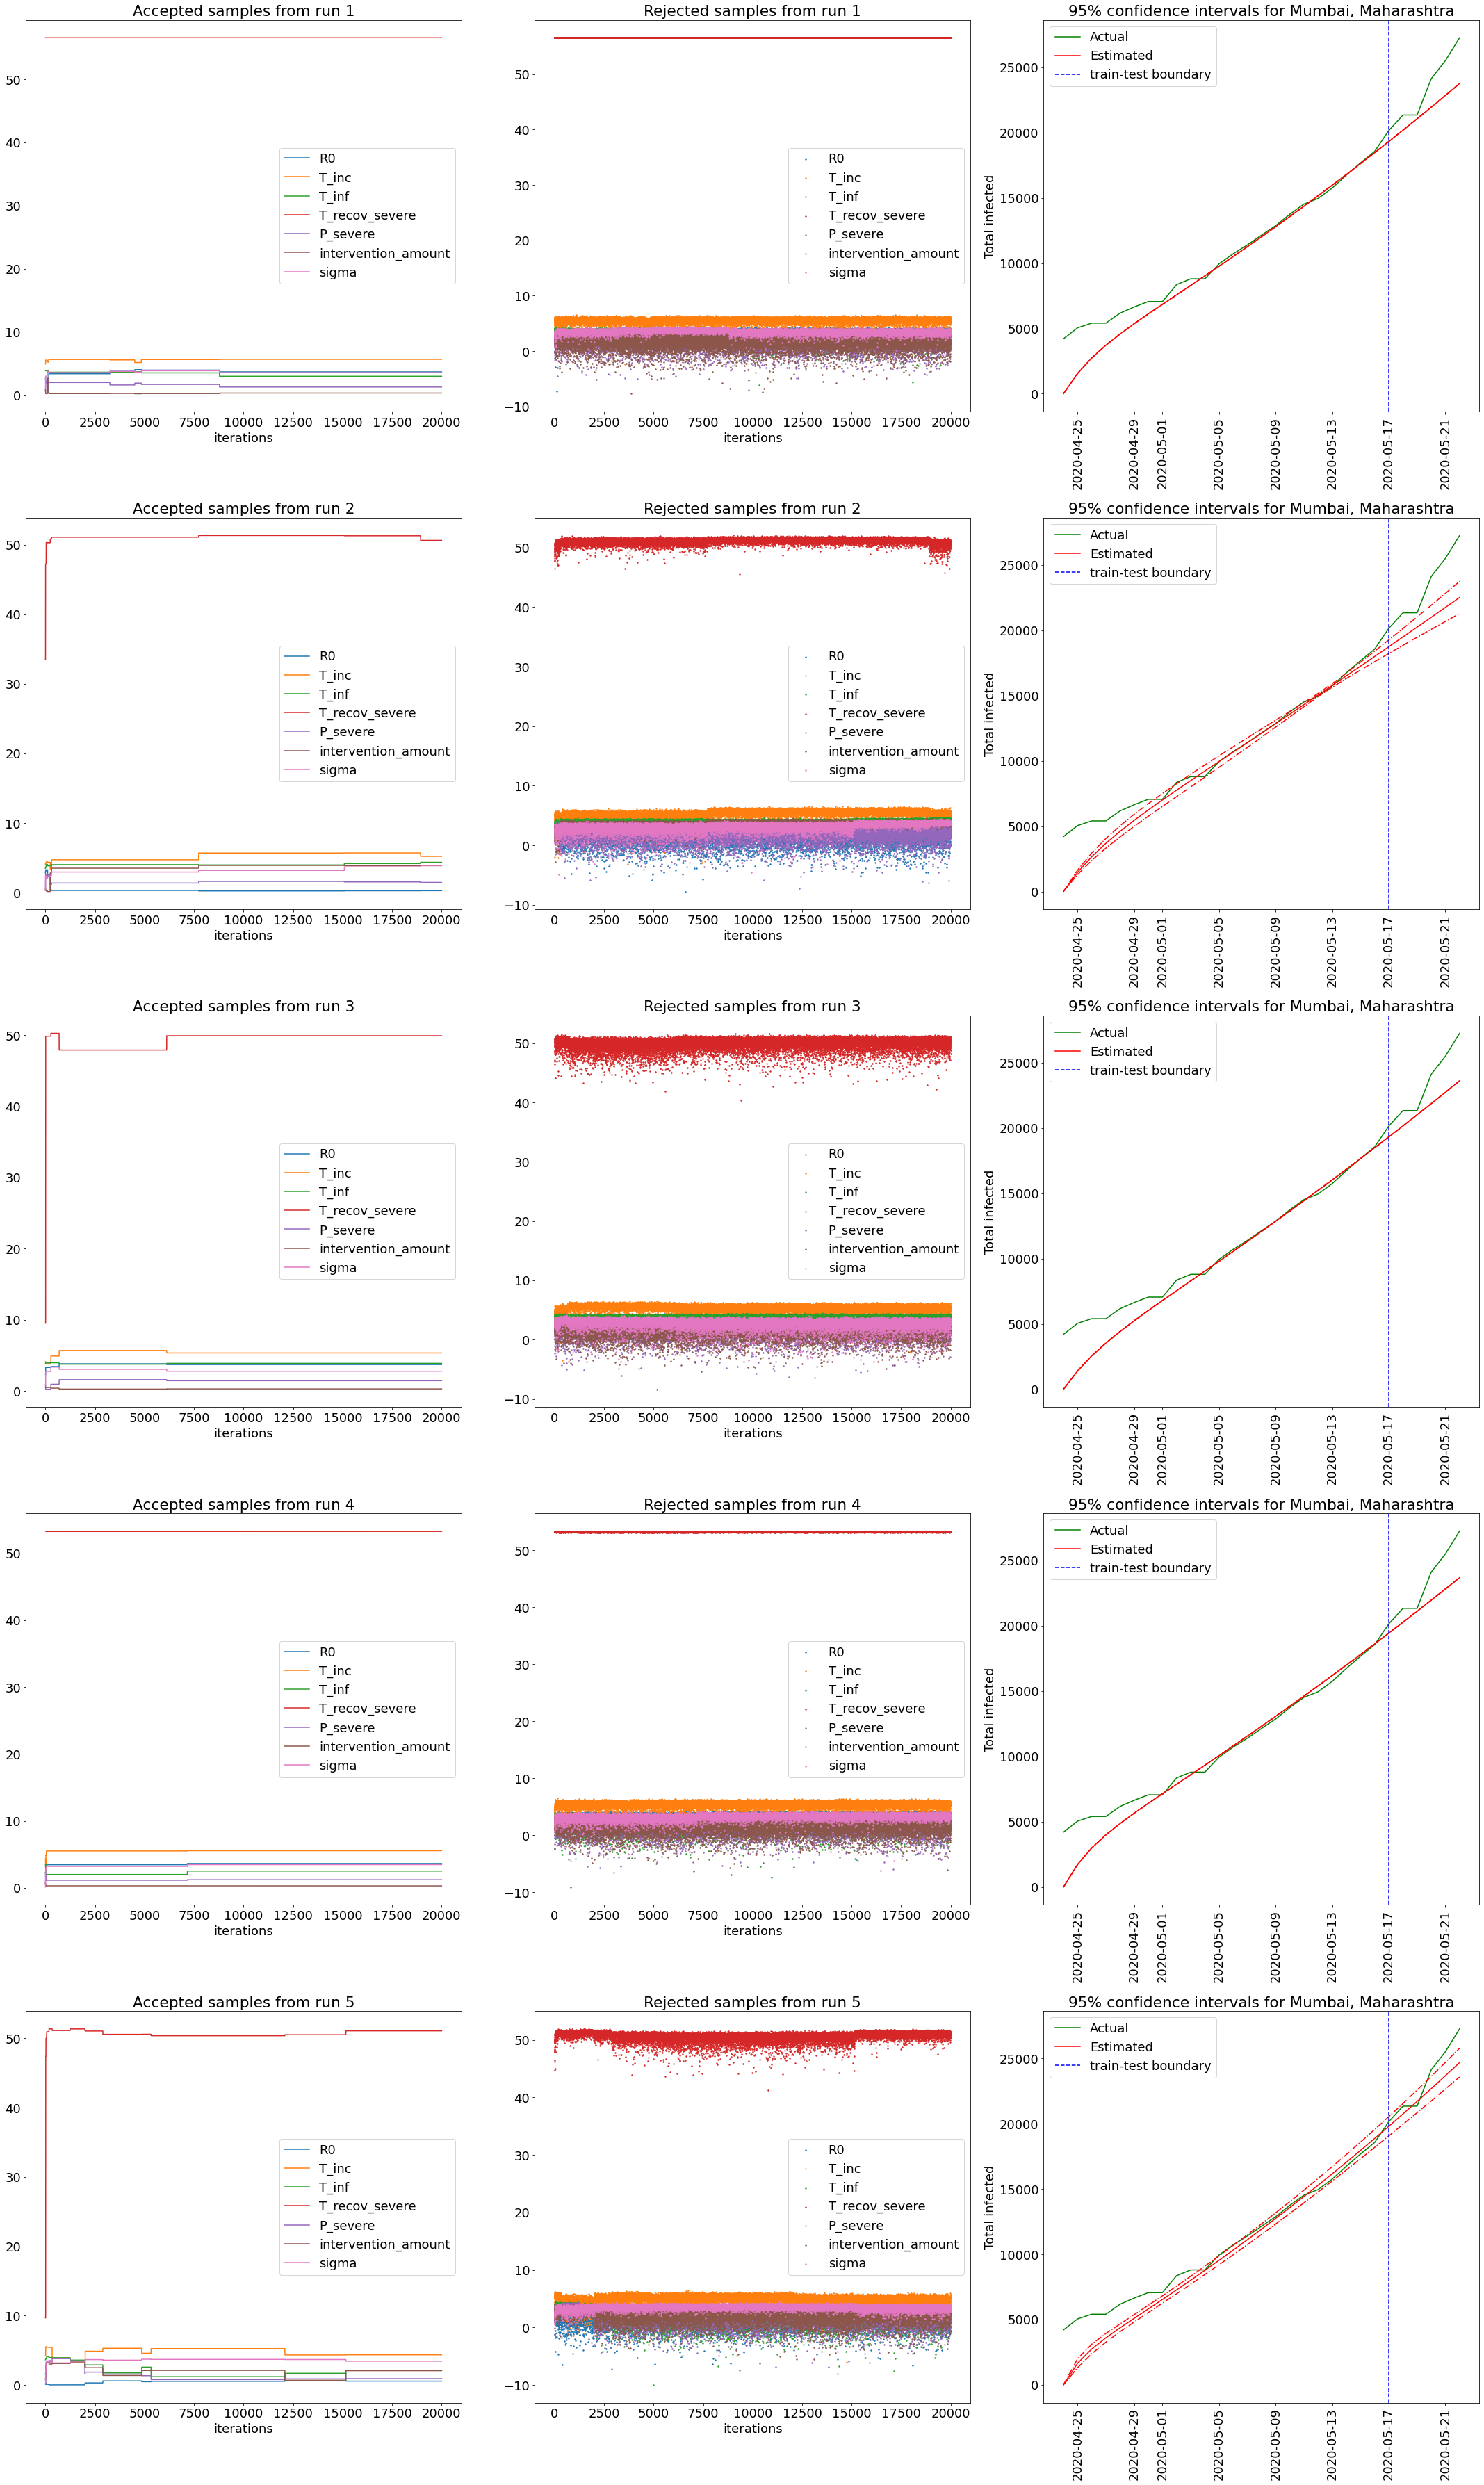

In [47]:
plt.figure(figsize=(30, 50))
    
for k, run in enumerate(mcmc):
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    acc, rej = run[0], run[1]
    df_samples = pd.DataFrame(acc)
    
    plt.subplot(len(mcmc), 3, 3*k + 1)
    for param in df_samples.columns:
        plt.plot(list(range(len(df_samples[param]))), df_samples[param], label=param)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Accepted samples from run {}".format(k+1))
    
    rej_samples = pd.DataFrame(rej)
    
    plt.subplot(len(mcmc), 3, 3*k + 2)
    for param in rej_samples.columns:
        plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Rejected samples from run {}".format(k+1))
    
    burn_in = int(len(acc) / 2)
    n_samples = 1000
    posterior_samples = acc[burn_in:]
    sample_indices = np.random.uniform(0, len(posterior_samples), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(posterior_samples[int(i)], default_params, data_split))
        
    for df in pred_dfs:
        df.set_index('date', inplace=True)
        
    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''
        
    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)
            
    data_split.set_index("date", inplace=True)

    plt.subplot(len(mcmc), 3, 3*k + 3)
    plt.plot(data_split.index.array, data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result.index.array, result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result.index.array, result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result.index.array, result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=df_train['date'][len(df_train)-1], c='b', linestyle='dashed', label='train-test boundary')
    plt.xticks(rotation=90)
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% confidence intervals for {}, {}".format(district, state))
    plt.tight_layout()
    
plt.savefig("./mcmc_runs_{}_{}.png".format(district, state))
plt.show()


## Checking validity with Gelman-Rubin statistics

Check Section 4.2 [here](http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf)

In [72]:
def accumulate(dict_list):
    accumulator = defaultdict(int)
    for elt in dict_list:
        for key in elt:
            accumulator[key]+=elt[key]
    return accumulator

def divide(dictvar, num):
    return {key:dictvar[key]/num for key in dictvar}

            
def avg_sum_chain(chain):
    chain_sums_avg = accumulate(chain)
    return divide(chain_sums_avg, len(chain))

def avg_sum_multiple_chains(chain_sums_avg):
    multiple_chain_sums_avg = accumulate(chain_sums_avg)
    return divide(multiple_chain_sums_avg, len(chain_sums_avg))

def compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m):
    B = defaultdict(int)
    for elt in chain_sums_avg:
        for key in elt:
            B[key] += np.square(elt[key] - multiple_chain_sums_avg[key])
    return divide(B, (m-1)/n)

def compute_W(split_chains, chain_sums_avg, n, m):
    s = []
    for j in range(m):
        s_j_sq = defaultdict(int)
        chain = split_chains[j]
        chain_sum_avg_j = chain_sums_avg[j]
        for i in range(n):
            chain_elt = chain[i]
            for key in chain_elt:
                s_j_sq[key] += np.square(chain_elt[key] - chain_sum_avg_j [key])
        s_j_sq = divide(s_j_sq, n - 1)
        s.append(s_j_sq)
    return (divide (accumulate(s),m))

def divide_dict(d1, d2):
    accumulator = defaultdict(int)
    for key in d1:
        accumulator[key] = d1[key]/d2[key]
    return accumulator

In [73]:
burn_in = int(len(mcmc[0][0]) / 2)
chains = [mcmc_chain[0] for mcmc_chain in mcmc]
burn_in = int(len(chains[0]) / 2)
sampled_chains = [chain[:burn_in] for chain in chains]
split_chains = [sampled_chain[int(burn_in/2):] for sampled_chain in sampled_chains] \
            + [sampled_chain[:int(burn_in/2)] for sampled_chain in sampled_chains]


In [74]:
chain_sums_avg = []
for chain in split_chains:
    chain_sums_avg.append(avg_sum_chain(chain))
multiple_chain_sums_avg = avg_sum_multiple_chains(chain_sums_avg) 

In [75]:
multiple_chain_sums_avg

{'R0': 2.3134299015564723,
 'T_inc': 5.699095927193388,
 'T_inf': 3.1717035264807505,
 'T_recov_severe': 100.64257288436087,
 'P_severe': 1.107954976034292,
 'intervention_amount': 0.6952490304744424,
 'sigma': 3.3768520343590573}

In [76]:
m = len(split_chains)
n = len(split_chains[0])
W =  compute_W(split_chains, chain_sums_avg, n, m)
B =  compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m)
var_hat = accumulate([divide(W, n/(n-1)), divide(B, n) ])
R_hat_sq = divide_dict(var_hat, W)
R_hat = {key:np.sqrt(value) for key, value in R_hat_sq.items()}
neff = divide_dict(var_hat, B)
neff = {key: m*n*value for key, value in neff.items()}

In [77]:
neff

{'R0': 14.591862390252214,
 'T_inc': 21.07501584064318,
 'T_inf': 10.605008558137529,
 'T_recov_severe': 112.12247118725404,
 'P_severe': 19.897524576480798,
 'intervention_amount': 23.488666331490126,
 'sigma': 11.296402458145298}

In [78]:
R_hat

{'R0': 1.782450576319272,
 'T_inc': 1.379330511199441,
 'T_inf': 4.186309361699954,
 'T_recov_severe': 1.0477127741167611,
 'P_severe': 1.4177276081835115,
 'intervention_amount': 1.319475223507566,
 'sigma': 2.951594698445619}